# Data Driven insights for a new movie studio

## Business Problem
The company is launching new movie studio but know nothing about film production. 
They are exploring what types of films are currently doing the best at the box office. Then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

## Objective
Determine the best performing genres and studios and their financial outcome to determine the investment and production decisions.

## Research Objectives
1. To determine the best performing genres according to ratings
2. To determine the best performing genre based on popularity(num of votes)
3. To analyze film performance across studios, years and domestic versus international markets

In [2]:
# import libraries
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1.0 Data Loading and Cleaning
Loading the datasets, data understanding and cleaning the data for analysis

The data of interest is the im.db database and the bom.movie_gross.csv dataset

In [3]:
# Loading the box office mojo dataset
bom = pd.read_csv("Data/bom.movie_gross.csv")
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [4]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [5]:
# Change foreign gross column to numeric
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce')

In [6]:
# Missing Values
bom.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1355
year                 0
dtype: int64

In [7]:
x= bom[bom['domestic_gross'].isna() & bom['foreign_gross'].isna()]
print(x)


Empty DataFrame
Columns: [title, studio, domestic_gross, foreign_gross, year]
Index: []


In [8]:
# Drop the rows with missing values in domestic gross and studio
bom = bom.dropna(subset=['domestic_gross', 'studio'])

In [9]:
# Fill missing values in foreign gross with median
bom['foreign_gross'].fillna(bom['foreign_gross'].median(), inplace=True)

In [10]:
bom['studio'].value_counts().head(10)

IFC      166
Uni.     147
WB       140
Fox      136
Magn.    136
SPC      123
Sony     109
BV       106
LGF      102
Par.     101
Name: studio, dtype: int64

In [11]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3356 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3356 non-null   object 
 1   studio          3356 non-null   object 
 2   domestic_gross  3356 non-null   float64
 3   foreign_gross   3356 non-null   float64
 4   year            3356 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 157.3+ KB


In [12]:
# Loading the SQL database
# Connect to the database
conn = sqlite3.connect("Data/im.db")

# Create cursor to execute sql commands
cur = conn.cursor()

In [13]:
# List all table names in the database
pd.read_sql("""SELECT name
            FROM sqlite_master
            WHERE type = 'table';
""",conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [14]:
# movie_basics table
pd.read_sql(""" 
        SELECT *
        FROM movie_basics
        LIMIT 5;      
""",conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [15]:
# Check for missing values in key columns

pd.read_sql("""
    SELECT 
        SUM(CASE WHEN primary_title IS NULL THEN 1 ELSE 0 END) AS missing_title,
        SUM(CASE WHEN start_year IS NULL THEN 1 ELSE 0 END) AS missing_year,
        SUM(CASE WHEN runtime_minutes IS NULL THEN 1 ELSE 0 END) AS missing_runtime,
        SUM(CASE WHEN genres IS NULL THEN 1 ELSE 0 END) AS missing_genre
    FROM movie_basics;
""", conn)

,missing_title,missing_year,missing_runtime,missing_genre
0,0,0,31739,5408


In [16]:
# Check for duplicates by 'movie_id' 
pd.read_sql("""
    SELECT movie_id, COUNT(*) AS count
    FROM movie_basics
    GROUP BY movie_id
    HAVING COUNT(*) > 1;
""", conn)

,movie_id,count


In [17]:
# Check Numeric ranges
pd.read_sql("""
    SELECT 
        MIN(start_year) AS min_year,
        MAX(start_year) AS max_year,
        MIN(runtime_minutes) AS min_runtime,
        MAX(runtime_minutes) AS max_runtime
    FROM movie_basics;
""", conn)

,min_year,max_year,min_runtime,max_runtime
0,2010,2115,1.0,51420.0


In [18]:
cur.execute("""
            DELETE FROM movie_basics
            WHERE start_year > 2025;          
""")
conn.commit()

In [19]:
# Movie_ratings table
pd.read_sql(""" 
            SELECT *
            FROM movie_ratings
            LIMIT 10;   
""", conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
5,tt1069246,6.2,326
6,tt1094666,7.0,1613
7,tt1130982,6.4,571
8,tt1156528,7.2,265
9,tt1161457,4.2,148


In [20]:
# check for missing values
pd.read_sql("""SELECT *
                FROM movie_ratings
                WHERE movie_id IS NULL
                OR averagerating IS NULL
                OR numvotes IS NULL;
""", conn)

,movie_id,averagerating,numvotes


In [21]:
# Checking ranges in the numeric columns
pd.read_sql("""
    SELECT 
           MIN(averagerating) AS min_rating,
           MAX(averagerating) AS max_rating,
           MIN(numvotes) AS min_votes,
           MAX(numvotes) AS max_votes
    FROM movie_ratings;
""", conn)

,min_rating,max_rating,min_votes,max_votes
0,1.0,10.0,5,1841066


In [22]:
# Remove rows with extremely low votes
cur.execute("""
            DELETE FROM movie_ratings
            WHERE numvotes < 100;          
""")
conn.commit()

### 2.0 Exploratory Data Analysis
### 2.1 Performance of genres based on the rating
Rate score can show how much the movie was likes.

The genres are merged to have one genre individually rather than the grouped genres

In [23]:
# Merge the movie_basics and movie_ratings tables
cur.execute("""
            CREATE TABLE imdb_merged AS
            SELECT 
                b.movie_id,
                b.primary_title,
                b.original_title,
                b.start_year,
                b.runtime_minutes,
                b.genres,
                r.averagerating,
                r.numvotes
            FROM movie_basics AS b
            INNER JOIN movie_ratings AS r
            ON b.movie_id = r.movie_id;
""")
conn.commit()

In [24]:
# Preview merged data
pd.read_sql("""
        SELECT * FROM imdb_merged LIMIT 5;
""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
1,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
2,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",8.1,263
3,tt0146592,Pál Adrienn,Pál Adrienn,2010,136.0,Drama,6.8,451
4,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89.0,Drama,6.9,120


In [35]:
pd.read_sql("""SELECT name FROM sqlite_master WHERE type='table';""",conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,imdb_merged


In [ ]:
# Duplicate dataframe and split multi-genre entries
imdb_merged = pd.read_sql("SELECT * FROM imdb_merged;", conn)


imdb_genre = imdb_merged.copy()
imdb_genre['genre_split'] = imdb_genre['genres'].str.split(',')

# Explode genres (so one genre per row)
imdb_genre = imdb_genre.explode('genre_split')

# Compute average, median and count of ratings per genre
genre_ratings = (
    imdb_genre.groupby('genre_split', as_index=False)
    .agg(
        avg_rating=('averagerating', lambda x: round(x.mean(), 2)),
        median_rating=('averagerating', lambda x: round(x.median(), 2)),
        total_votes=('numvotes', 'sum'),
        movie_count=('primary_title', 'count')
    )
    .sort_values(by='avg_rating', ascending=False)
)

# Display results
print(genre_ratings.head(10))

,genre_split,avg_rating,median_rating,total_votes,movie_count
17,News,7.13,7.3,112430,113
7,Documentary,7.09,7.2,4419900,3537
4,Biography,6.88,7.0,21552395,1461
14,Music,6.70,6.9,5420397,711
12,History,6.67,6.8,7798403,1007
21,Sport,6.60,6.8,3737919,517
3,Animation,6.31,6.5,15325900,865
23,War,6.26,6.5,2672421,406
15,Musical,6.22,6.3,1375198,248
8,Drama,6.16,6.3,119069859,13803


In [31]:
print(genre_ratings.tail(10))

   genre_split  avg_rating  median_rating  total_votes  movie_count
16     Mystery        5.63           5.70     24614874         1589
11   Game-Show        5.60           5.60         3462            1
0       Action        5.56           5.70    101073306         3968
10     Fantasy        5.56           5.75     26303072         1032
24     Western        5.40           5.50      2448024          123
22    Thriller        5.38           5.40     48039281         4432
20      Sci-Fi        5.08           5.30     42929678         1163
18  Reality-TV        4.80           4.80          171            1
13      Horror        4.67           4.70     23756944         3549
1        Adult        2.00           2.00          128            1


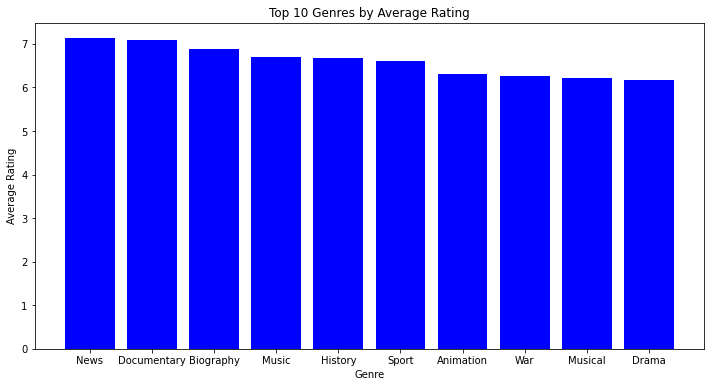

In [59]:
# Visual representation of the top 10 rated genres

# top 10 genres by average rating
top10_genres = genre_ratings.head(10)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top10_genres['genre_split'], top10_genres['avg_rating'], color='blue')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Top 10 Genres by Average Rating')
plt.show()

The graph shows that News, Documentary and Biography are the top-rated genres on average, with News having the highest average rating of 7.13. 
This suggests that audiences tend to favor movies in these genres in terms of quality. 
Genres like Reality_TV, Horror and Adult while popular, have slightly lower average ratings among the top 10.

### 2.2 Performance of genre based on popularity(number of votes)
The number of votes could be used to determine the votes with a bigger audience or more popular

In [73]:
# Average number of votes per genre
imdb_genre[imdb_genre['movie_id']=='tt0100275']

average_votes = (
    imdb_genre.groupby('genre_split', as_index=False)
    .agg(
        avg_votes=('numvotes', lambda x: round(x.mean(), 2)),
        movie_count=('primary_title', 'count')
    )
    .sort_values(by='avg_votes', ascending=False)
)
print("Top 5 with highest average votes")
print(average_votes.head())
print("---------------------------------")
print("Top 5 with lowest average votes")
print(average_votes.tail())

Top 5 with highest average votes
   genre_split  avg_votes  movie_count
2    Adventure   43014.10         1957
20      Sci-Fi   36912.88         1163
10     Fantasy   25487.47         1032
0       Action   25472.10         3968
24     Western   19902.63          123
---------------------------------
Top 5 with lowest average votes
    genre_split  avg_votes  movie_count
11    Game-Show    3462.00            1
7   Documentary    1249.62         3537
17         News     994.96          113
18   Reality-TV     171.00            1
1         Adult     128.00            1


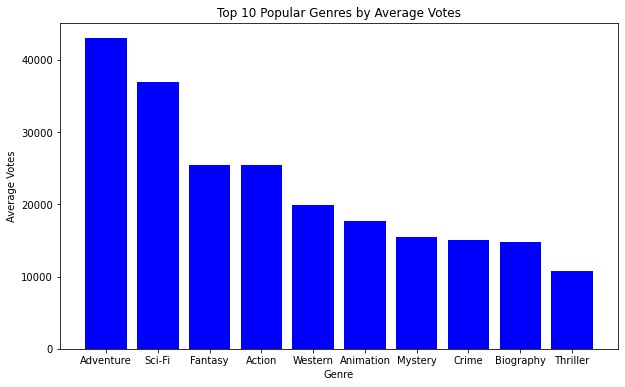

In [74]:
# Visual representation of the top 10 popular genres

# top 10 genres by highest vote count
top10_popular_genres = average_votes.head(10)

# Plot
plt.figure(figsize=(10,6))
plt.bar(top10_popular_genres['genre_split'], top10_popular_genres['avg_votes'], color='blue')
plt.xlabel('Genre')
plt.ylabel('Average Votes')
plt.title('Top 10 Popular Genres by Average Votes')
plt.show()

Genres like Adventure, Sci-Fi and Fantasy dominate audience attention and generate the highest average votes per movie.
Genres like Documentary are have low average votes or have smaller audiences even if there are many movies.
This can guide studios on which genres have both high engagement and high potential for audience reach.
The studio can balance high-reach genres with niche genres to diversify content and capture both mass and loyal niche audiences.

  genre_split  total_votes  movie_count
0      Action    101073306         3968
1       Adult          128            1
2   Adventure     84178601         1957
3   Animation     15325900          865
4   Biography     21552395         1461


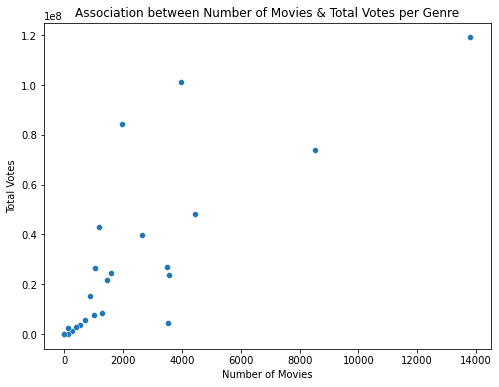

In [ ]:

# Total votes per genre
total_votes_genre = (
    imdb_genre.groupby('genre_split', as_index=False)
    .agg(
        total_votes=('numvotes', 'sum'),
        movie_count=('primary_title', 'count')
    )
)
print(total_votes_genre.head())

# Scatter plot 

plt.figure(figsize=(8,6))
sns.scatterplot(x='movie_count', y='total_votes', data=total_votes_genre)
plt.xlabel('Number of Movies')
plt.ylabel('Total Votes')
plt.title('Association between Number of Movies & Total Votes per Genre')
plt.show()


In [79]:
correlation = total_votes_genre['movie_count'].corr(total_votes_genre['total_votes'])
print(f"Correlation between movie count and total votes: {correlation:.2f}")


Correlation between movie count and total votes: 0.79


In [ ]:
### There is a strong positive relationship between the number of movies and the number of votes
### This means that the number of movies produced influence the number of votes.

### 2.3 To analyze film performance across studios, years and domestic versus international markets
Studio Performance in terms of revenue

In [82]:
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


In [181]:
bom.describe()

,domestic_gross,foreign_gross,year,total_gross,total_gross_millions
count,3.356000e+03,3.356000e+03,3356.000000,3.356000e+03,3356.000000
mean,2.877149e+07,5.323293e+07,2013.970203,8.200441e+07,82.004415
std,6.700694e+07,1.103313e+08,2.479064,1.681636e+08,168.163571
min,1.000000e+02,6.000000e+02,2010.000000,4.900000e+03,0.004900
25%,1.200000e+05,1.240000e+07,2012.000000,1.960810e+07,19.608100
50%,1.400000e+06,1.960000e+07,2014.000000,2.022600e+07,20.226000
75%,2.795000e+07,2.970000e+07,2016.000000,6.272500e+07,62.725000
max,9.367000e+08,9.605000e+08,2018.000000,1.518900e+09,1518.900000


In [ ]:
# Grouped studios with the number of movies produced
top_studios = bom['studio'].value_counts()
print("The top 5 studios by count:")
print(top_studios.head())


The top 5 studios by count:
IFC      166
Uni.     147
WB       140
Fox      136
Magn.    136
Name: studio, dtype: int64


2010

In [92]:
# Calculate the total gross and add column for total gross to millions for easy understanding
bom['total_gross'] = bom['domestic_gross'] + bom['foreign_gross']
bom['total_gross_millions'] =bom['total_gross']/1000000
bom.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,total_gross_millions
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09,1067.0
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09,1025.5
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08,960.3
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08,828.3
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08,752.6


In [176]:
# Grouped studios with the mean total gross
studio_analysis = bom.groupby('studio')['total_gross_millions'].agg(
    ['mean', 'median', 'count']).sort_values(by='mean', ascending=False)
studio_analysis.head(10)

,mean,median,count
studio,,,
HC,870.300000,870.30,1
P/DW,507.650000,524.95,10
BV,417.842277,215.95,106
GrtIndia,254.200000,254.20,1
WB (NL),230.095556,148.90,45
Fox,228.268872,158.50,136
WB,221.656779,112.15,140
Sony,206.268983,147.50,109
Uni.,203.229667,125.50,147


In [98]:
bom[bom['studio']== 'HC']

,title,studio,domestic_gross,foreign_gross,year,total_gross,total_gross_millions
2764,Wolf Warrior 2,HC,2700000.0,867600000.0,2017,870300000.0,870.3


In [100]:
bom[bom['studio']== 'GrtIndia']

,title,studio,domestic_gross,foreign_gross,year,total_gross,total_gross_millions
2796,Baahubali 2: The Conclusion,GrtIndia,20200000.0,234000000.0,2017,254200000.0,254.2


In [177]:
#Check if some studios perform significantly better (higher gross) than others.
# One-way ANOVA
from scipy.stats import f_oneway

# Ho: The mean gross is the same across all studios.
# H1: At least one studio has a significantly different mean gross.


groups = [group['total_gross'] for name, group in bom.groupby('studio')]
f_stat, p = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}, P-value: {p:.3f}")

#Reject Ho since p_value(0.00) < than 0.05
'''
Atleast one studio has a difference in the mean if the gross income
The type of films the best performing studios produce have a higher income
'''


F-statistic: 6.991, P-value: 0.000


'\nAtleast one studio has a difference in the mean if the gross income\nThe type of films the best performing studios produce have a higher income\n'

Year performance in terms of revenue collected which imply the trends


In [178]:
# Grouped year with the mean total gross
year_analysis = bom.groupby('year')['total_gross_millions'].agg(
    ['mean', 'median', 'count']).sort_values(by='mean', ascending=False)
year_analysis.head(10)

,mean,median,count
year,,,
2017,105.264369,21.5500,320
2018,101.400322,20.6680,308
2013,87.578470,20.9000,345
2016,80.735895,20.3010,433
2012,78.421351,19.9660,393
2014,77.825639,20.1850,390
2010,77.020499,19.3522,322
2011,70.213522,19.8780,396
2015,69.801689,19.9700,449


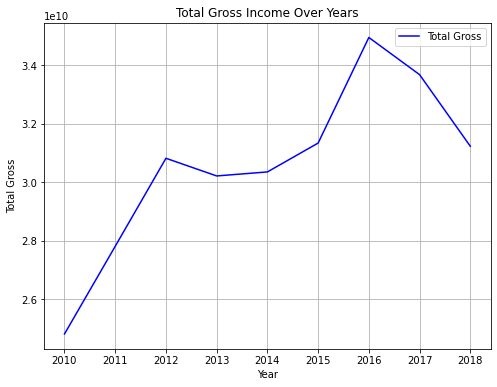

In [187]:
yearly_gross = bom.groupby('year', as_index=False)['total_gross'].sum()

plt.figure(figsize=(8,6))
plt.plot(yearly_gross['year'], yearly_gross['total_gross'], label='Total Gross', color='blue')
plt.title("Total Gross Income Over Years")
plt.xlabel("Year")
plt.ylabel("Total Gross")
plt.xticks(yearly_gross['year'])  # ensures all years are shown
plt.legend()
plt.grid(True)
plt.show()


The high performance of 2016 and 2017 suggests that the industry is still capable of generating massive revenue

In [179]:
# Check if average film gross has changed significantly over time (e.g., trends).
# One-way ANOVA.

# Ho: Average gross has not changed across years.
# H1: Average gross differs across years.

groups = [group['total_gross'] for name, group in bom.groupby('year')]
f_stat, p = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}, P-value: {p:.3f}")

# Reject Ho since p_value(0.00) < than 0.05

'''
Atleast one year has a difference in the mean if the gross income.
Focus on the most profitable years and examine what genres or themes dominated them.
'''

F-statistic: 1.959, P-value: 0.048


'\nAtleast one year has a difference in the mean if the gross income.\nFocus on the most profitable years and examine what genres or themes dominated them.\n'

#### Hypothesis Testing
Using the alpha(confidence level) = 0.05

##### Using Pearsons correlation to Check relationship between domestic gross and foreign gross.

In [143]:
# Correlation between domestic and foreign

# Ho: There is no linear relationship between domestic and foreign gross.
# H1: There is a significant linear relationship between domestic and foreign gross.
from scipy import stats
from scipy.stats import pearsonr

r, p_value = pearsonr(bom['domestic_gross'], bom['foreign_gross'])

print(f"Correlation coefficient (r): {r:.3f}")
print(f"P-value: {p_value:.3f}")

 # When the p_value is < 0.05 Reject the Null Hypothesis

Correlation coefficient (r): 0.786
P-value: 0.000


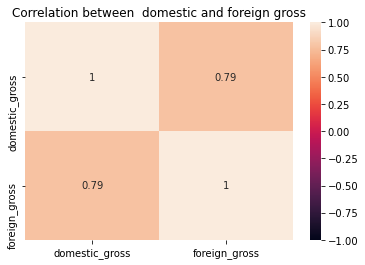

In [171]:
# Heatmap to show correlation between domestic and foreign gross
corr= bom[['domestic_gross', 'foreign_gross']].corr()
sns.heatmap(corr, annot=True,vmin=-1, vmax=1)
plt.title("Correlation between  domestic and foreign gross")
plt.show()

In [ ]:
"""
There is a strong positive correlation between domestic and foreign market
The null hypothesis is rejected indicating there is a linear relationship between domestic gross and foreign gross

The studio can safely assume that films successful locally are likely to perform well internationally 
Investment in global marketing can increase profit.
"""

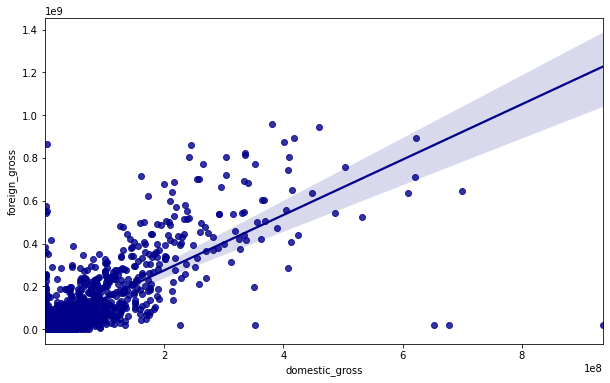

In [ ]:
# Plot to show the relationship between domestic and foreign income
plt.figure(figsize=(10,6))
# sns.scatterplot(data=bom, x='domestic_gross', y='foreign_gross',color='darkblue')
sns.regplot(data= bom, x='domestic_gross', y='foreign_gross', color='darkblue')
plt.show()


In [ ]:
# Perform a paired ttest to compare the means between the domestic and foreign income

#Ho: There is no difference in means between the domestic and foreign income (mean domestic == mean foreign)
#H1: There is a difference in means between the domestic and foreign income (mean domestic != mean foreign)

t_stat, p_val = stats.ttest_rel(bom['domestic_gross'], bom['foreign_gross'])
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_val:.3f}")

# When p_value is < 0.05 Reject the Null Hypothesis
'''
In conclusion there is a difference in means between domestic and foreign gross.
Technically one earns more.
'''


T-Statistic: -19.947, P-Value: 0.000


In [ ]:
bom[['domestic_gross', 'foreign_gross']].mean()

'''
The foreign gross technically earns higher!
'''

domestic_gross    2.877149e+07
foreign_gross     5.323293e+07
dtype: float64

In [ ]:
# bom=bom.drop(columns=['log_domestic_gross', 'log_foreign_gross', 'difference'], axis=1)

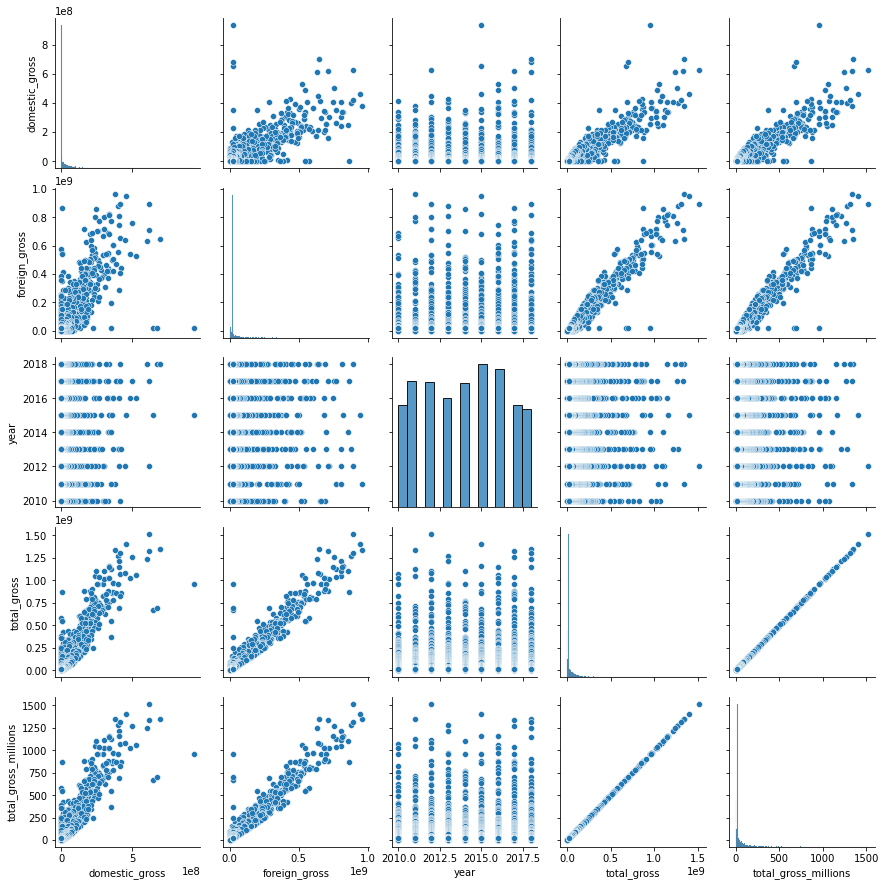

In [165]:
sns.pairplot(bom)

### 3.0 Conclusion
In conclusion, the datasets used are the im.db dataset and the box office mojo(bom.movie_gross.csv) dataset to conduct the analysis.
1. **Based on the rating:**  
    News, Documentary and Biography are the top-rated genres on average, suggesting that audiences tend to favor movies in these genres in terms of quality. Genres like Reality_TV, Horror and Adult while popular, have slightly lower average ratings.

2. **Based of popularity:**  
    Adventure, Sci-Fi and Fantasy genres dominate audience attention and generate the highest average votes per movie.Genres like Documentary are have low average votes or have smaller audiences even if there are many movies.
    This can guide studios on which genres have both high engagement and high potential of audience reach.
    Though the number of votes is highly influenced by the number of movies in the genre with a corr=(0.7).

3. **Based on the income generation:**  
    An ANOVA test confirmed that there is a significant difference in mean gross income among film studios, meaning certain studios consistently outperform others financially. Benchmarking the HC(Hallmark), P/DW(Paramount DreamWorks) to see the type of films they produce thus their high income is a great strategy to determine the best films to invest in.

    There is a strong positive correlation (0.79) between domestic gross and foreign gross.A film that is successful in the domestic market is highly likely to perform well internationally. Investing in global marketing for films that perform well domestically is a strong strategy to increase overall profit.

    There is also an upward trend in the gross total income of the movies over the years suggesting that the studio is likey to make profit.

